In [1]:
from SciTech2022_inference import current_model
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [94]:
def mapminmax(x, xmin, xmax, ymin, ymax, direction='Forward'):
    """
    Pre and post process feedforwardnet,
    Ni: number of inputs
    No: number of outputs
    Nd: number of data samples
    :param x: (Ni,Nd) if 'Forward', (No,Nd) if 'Reverse', data that is to be mapped
    :param xmin: (Ni,1) if 'Forward', (No,1) if 'Reverse': minimum x value from NN training
    :param xmax: (Ni,1) if 'Forward', (No,1) if 'Reverse': maximum x value from NN training
    :param ymin: (1,1) mapping minimum for both NN inputs/outputs (assume they use the same mapping)
    :param ymax: (1,1) mapping maximum for both NN inputs/outputs (assume they use the same mapping)
    :param direction: 'Forward' for network inputs, 'Reverse' for network outputs
    :return:
    """
    if direction == 'Forward':
        # Apply the mapping x -> xnorm
        Ni, Nd = x.shape
        xmin_tile = np.tile(xmin, (1,Nd))
        xmax_tile = np.tile(xmax, (1,Nd))
        xnorm = np.divide((x - xmin_tile),(xmax_tile-xmin_tile))*(ymax-ymin) + ymin
        return xnorm
    elif direction == 'Reverse':
        # Undo the mapping y -> ynorm (equivalently, apply the mapping ynorm -> y)
        No, Nd = x.shape
        ynorm = x # raw network output is already normalized
        ynorm_min = ymin
        ynorm_max = ymax
        ymin_tile = np.tile(xmin,(1,Nd))
        ymax_tile = np.tile(xmax,(1,Nd))
        ratio = (ynorm - ynorm_min)/(ynorm_max-ynorm_min)
        y = np.multiply(ratio, (ymax_tile - ymin_tile)) + ymin_tile
        return y
    else:
        print(f'Incorrect direction: {direction}')

def net(weights_file, geom, V0=1000, N=200):
    """
    Forward prediction of Electric field from NN surrogate
    :param weights_file: Path to NN weights .mat file
    :param geom: (5,) array of emitter geometry [d, rc, alpha, h, ra]
    :param V0: Bias voltage (default: 1000V)
    :param N: Number of discretization points of emitter surface (default: 200)
    :return: (s, E_x, E_y) => cartesian components of electric field at s locations on emitter surface
    """
    d = geom[0]     # Tip-to-extractor distance [m]
    rc = geom[1]    # Radius of curvature [m]
    alpha = geom[2] # Cone half-angle [rad]
    h = geom[3]     # Emitter height [m]
    ra = geom[4]    # Radius of aperture [m]

    # Format geometry for the network (non-dimensionalize)
    x = np.array([d/h, rc/h, alpha, ra/h]).T
    x = np.tile(np.reshape(x,(4,1)),(1,N))
    s = np.linspace(0,1,N).reshape(1,N)
    x = np.concatenate((x,s))

    # Load weights and biases
    data = scipy.io.loadmat(weights_file)
    IW = data['IW'][0,0]    # input weights
    LW = data['LW']         # layer weights
    b = data['bias']        # biases
    num_layers = b.shape[0] - 1

    # Network preprocessing (mapminmax normalization)
    in_params = data['input_params'][0,0]
    xmax = in_params[2]
    xmin = in_params[3]
    ymax = np.squeeze(in_params[6])
    ymin = np.squeeze(in_params[7])
    xnorm = mapminmax(x, xmin, xmax, ymin, ymax, direction='Forward')

    # Input layer
    activation = np.tanh(IW @ xnorm + np.tile(b[0,0],(1,N)))

    # Hidden layers
    for l in range(num_layers):
        if l < num_layers - 1:
            activation = np.tanh(LW[l+1, l] @ activation + np.tile(b[l+1,0],(1,N)))
        else:
            # Linear activation for output regression layer
            activation = LW[l+1, l] @ activation + np.tile(b[l+1,0],(1,N))

    # Network postprecessing (undo mapminmax)
    out_params = data['output_params'][0,0]
    xmax = out_params[2]
    xmin = out_params[3]
    ymax = np.squeeze(out_params[6])
    ymin = np.squeeze(out_params[7])
    y = mapminmax(activation, xmin, xmax, ymin, ymax, direction='Reverse')

    # Re-dimensionalize
    E_x = y[0,:] * (V0/h)
    E_y = y[1,:] * (V0/h)

    return np.squeeze(s), E_x, E_y

In [181]:
Nr = 1      # number of realizations
Ne = 576    # number of emitters

# Model parameters (zeta_1, zeta_2, b_0)
params = np.array([1.18, 7.35e-3, 7e-6])
# params = np.array([2.57, 1.69e-2, 2e-5])

# Voltage prediction locations
voltage = np.linspace(0,2000,1000)

# Substrate properties
rp = np.mean([5e-6, 8e-6])  # pore radius [m]
kappa = 1.51e-13            # permittivity [m^-2]
subs = np.array([[rp], [kappa]])
subs.reshape(2,Nr)

# Material properties
k = np.mean([1.147, 1.39])              # conductivity [Sm^-1]
gamma = np.mean([5.003e-2, 5.045e-2])   # surface tension [N/m]
rho = np.mean([1.28e3, 1.284e3])        # density [kg/m^3]
mu = np.mean([2.612e-2, 3.416e-2])      # viscosity [N-s/m^2]
props = np.array([k, gamma, rho, mu]).T.reshape(4,Nr)

# Propellant properties
qm_ratio = 5.5e5          # charge to mass ratio [C/kg]
beams = np.array([qm_ratio]).reshape(1,Nr)

# Geometry parameters
rc = np.mean([1e-5, 2e-5])
d = 3e-6
ra = 2.486e-4
alpha = 2.678e-1
h = 3.018e-4
rpl = 6.5e-7
geoms = np.array([rc, d, ra, alpha, h, rpl])
geoms = np.tile(geoms[:,np.newaxis],(1,Ne)).reshape(6,Ne,Nr)

# Get surrogate Efield solution
wfile = 'dffnet_weights.mat'
emitter_geo = np.array([d, rc, alpha, h, ra])
V0 = 1000;
s, Ex, Ey = net(wfile, emitter_geo, V0=V0)
Emax = max(np.sqrt(np.square(Ex) + np.square(Ey)))/V0; # format for es_model
# es_model = np.ones((1,Ne,Nr))*Emax
es_model = np.ones((1,Ne,Nr))*(4.64e7/V0)

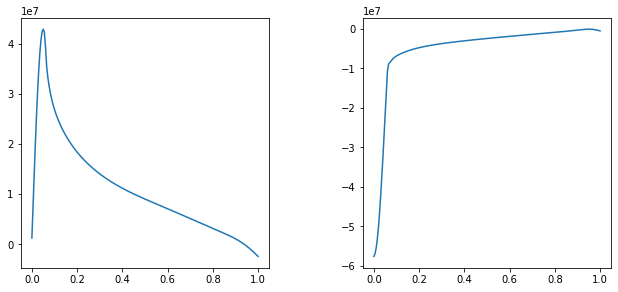

In [182]:
fig, ax = plt.subplots(1,2)
ax[0].plot(s,Ex)
ax[1].plot(s,Ey)
fig.tight_layout(pad=3.0)
fig.set_size_inches(10,5)
plt.show()

In [183]:
current = current_model(params,voltage,subs,props,beams,geoms,es_models=es_model)

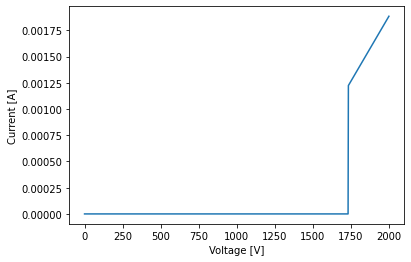

In [186]:
fig = plt.figure()
plt.plot(voltage,current)
rect = fig.patch
rect.set_facecolor('white')
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.show()

In [162]:
max(current)

array([0.])